In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pp
from pandas. plotting import scatter_matrix

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
# drop column 'Unnamed' & 'id'
train.drop(columns=['Unnamed: 0', 'id'], inplace=True)
test.drop(columns=['Unnamed: 0', 'id'], inplace=True)

### Generate data analysis report

In [4]:
profile = pp.ProfileReport(train)

In [ ]:
profile

In [4]:
# drop Arrival Delay in Minutes (highly correlated with Departure Delay)
train.drop(columns='Arrival Delay in Minutes', inplace=True)
test.drop(columns='Arrival Delay in Minutes', inplace=True)

### Label Encoder

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
cat_attributes = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Baggage handling', 'satisfaction']

number = LabelEncoder()

for col in cat_attributes:
    train[col] = number.fit_transform(train[col].astype('str'))
    test[col] = number.fit_transform(test[col].astype('str'))

In [7]:
# 'satisfied' should be encoded to 1 
train.satisfaction = abs(train.satisfaction-1)
test.satisfaction = abs(test.satisfaction-1)

### Split features and labels

In [8]:
X_train_raw = train.drop(columns='satisfaction')
y_train = train.satisfaction
X_test_raw = test.drop(columns='satisfaction')
y_test = test.satisfaction

### Scaling (necessary for logistic regression)

In [9]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

### Logistic Regression

In [30]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train, X_train)
result=logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.347519
         Iterations 7


In [31]:
print(result.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.492     
Dependent Variable: satisfaction     AIC:              72259.2224
Date:               2021-02-17 17:35 BIC:              72459.7981
No. Observations:   103904           Log-Likelihood:   -36109.   
Df Model:           20               LL-Null:          -71094.   
Df Residuals:       103883           LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1       -0.0285     0.0095    -3.0052   0.0027   -0.0472   -0.0099
x2        0.8207     0.0110    74.5636   0.0000    0.7992    0.8423
x3        0.1125     0.0101    11.1167   0.0000    0.0927    0.1323
x4        1.2637     0.0

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [33]:
lr.score(X_train, y_train)

0.8753945950107792

### XGBoost

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
xgb = GradientBoostingClassifier(max_depth=4, random_state=0)
xgb.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, random_state=0)

In [11]:
xgb.score(X_train, y_train)

0.9525234832152757

### RandomForest

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=4, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, random_state=0)

In [38]:
rf.score(X_train, y_train)

0.9124287804126886

### Feature importance
##### Choose XGBoost to present the feature importance since XGBoost has the best accuracy

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.03057
Feature: 2, Score: 0.00348
Feature: 3, Score: 0.15648
Feature: 4, Score: 0.05757
Feature: 5, Score: 0.00099
Feature: 6, Score: 0.22972
Feature: 7, Score: 0.00033
Feature: 8, Score: 0.00195
Feature: 9, Score: 0.00274
Feature: 10, Score: 0.00008
Feature: 11, Score: 0.40322
Feature: 12, Score: 0.00883
Feature: 13, Score: 0.03354
Feature: 14, Score: 0.01013
Feature: 15, Score: 0.01291
Feature: 16, Score: 0.00597
Feature: 17, Score: 0.02278
Feature: 18, Score: 0.00874
Feature: 19, Score: 0.00890
Feature: 20, Score: 0.00105


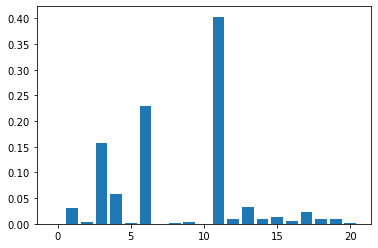

In [39]:
from matplotlib import pyplot
# get importance
importance = xgb.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Measuring Accuracy Using Cross-Validation
##### We could tolerate higher recall if we want to detect more unsatisfaction (recall above 0.9 is acceptable, if too low then FP is too high)

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

In [13]:
y_train_pred = cross_val_predict(xgb, X_train, y_train,cv=3)
confusion_matrix(y_train, y_train_pred)

array([[41858,  3167],
       [ 1794, 57085]], dtype=int64)

In [14]:
print("Precision score: ")
print(precision_score(y_train,y_train_pred))
print("Recall score: ")
print(recall_score(y_train, y_train_pred))
print("F1 score: ")
print(f1_score(y_train, y_train_pred))

Precision score: 
0.9474374294629224
Recall score: 
0.9695307325192344
F1 score: 
0.958356766920449


In [15]:
y_scores = cross_val_predict(xgb, X_train, y_train, cv=3, method="decision_function")

In [16]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds=precision_recall_curve(y_train,y_scores)

### Find optimal threshold (highest precision under the premise of recall > 0.9)

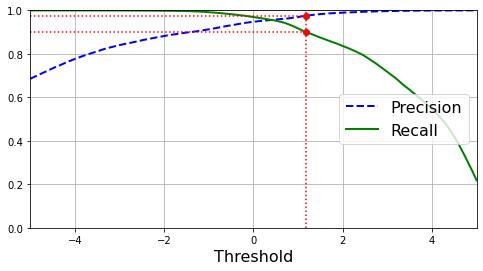

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-5, 5, 0, 1])             



precision_90_precision = precisions[np.argmin(recalls >= 0.9)]
threshold_90_precision = thresholds[np.argmin(recalls >= 0.9)]


plt.figure(figsize=(8, 4))                                                                
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., threshold_90_precision], "r:")             
plt.plot([-5, threshold_90_precision], [0.9, 0.9], "r:")                        
plt.plot([-5, threshold_90_precision], [precision_90_precision, precision_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                          
plt.plot([threshold_90_precision], [precision_90_precision], "ro")                 
plt.show()

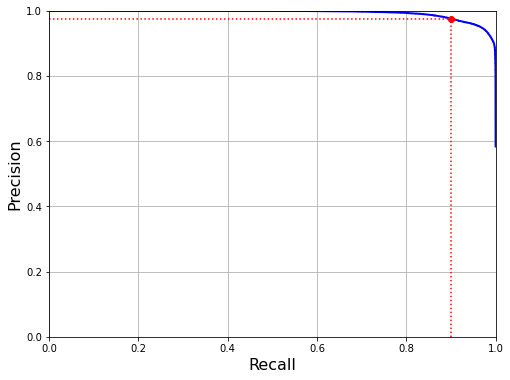

In [46]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.9, 0.9], [0., 0.9752], "r:")
plt.plot([0.0, 0.9], [0.9752, 0.9752], "r:")
plt.plot([0.9], [0.9752], "ro")
plt.show()

### Model performace after setting threshold

In [47]:
threshold_90_precision=thresholds[np.argmin(recalls>=0.9)]

In [48]:
threshold_90_precision

1.1823207137416156

In [49]:
y_train_pred_90=(y_scores >= threshold_90_precision)

In [53]:
(sum(y_train_pred_90==y_train) / len(y_train))

0.9303780412688636

In [50]:
precision_score(y_train, y_train_pred_90)

0.9752286655501776

In [43]:
recall_score(y_train, y_train_pred_90)

0.8999983016015897

In [51]:
f1_score(y_train, y_train_pred_90)

0.9361044375353308

In [52]:
confusion_matrix(y_train, y_train_pred_90)

array([[43679,  1346],
       [ 5888, 52991]], dtype=int64)

### ROC curve

In [46]:
from sklearn.metrics import roc_curve

In [50]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

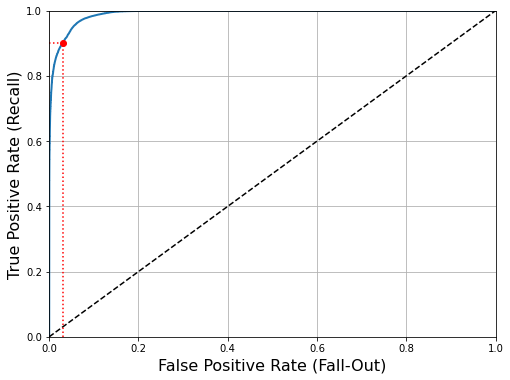

In [54]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([0.0299, 0.0299], [0., 0.9], "r:") # Not shown
plt.plot([0.0, 0.0299], [0.9, 0.9], "r:")  # Not shown
plt.plot([0.0299], [0.9], "ro")               # Not shown
plt.show()

In [52]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, y_scores)

0.9910342589026276

### Test set

In [110]:
y_test_pred = xgb.decision_function(X_test)

In [111]:
y_test_pred_90 = (y_test_pred >= threshold_90_precision)

In [112]:
sum(y_test_pred_90==y_test) / len(y_test)

0.9344779796735448

In [117]:
precision_score(y_test, y_test_pred_90)

0.9759633163227572

In [114]:
recall_score(y_test, y_test_pred_90)

0.9055101900775406

In [115]:
f1_score(y_test, y_test_pred_90)

0.9394176692532213

In [116]:
confusion_matrix(y_test, y_test_pred_90)

array([[11078,   325],
       [ 1377, 13196]], dtype=int64)